In [45]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy

In [226]:
STATES = 100
ACTIONS = 20
GAMMA = 0.999

In [119]:
rewards = np.random.uniform(size=(STATES, ACTIONS))
p_mat = np.random.uniform(size=(STATES, ACTIONS, STATES))
norms = p_mat.sum(axis=2)
p_mat /= norms[:, :, np.newaxis]

<IPython.core.display.Javascript object>


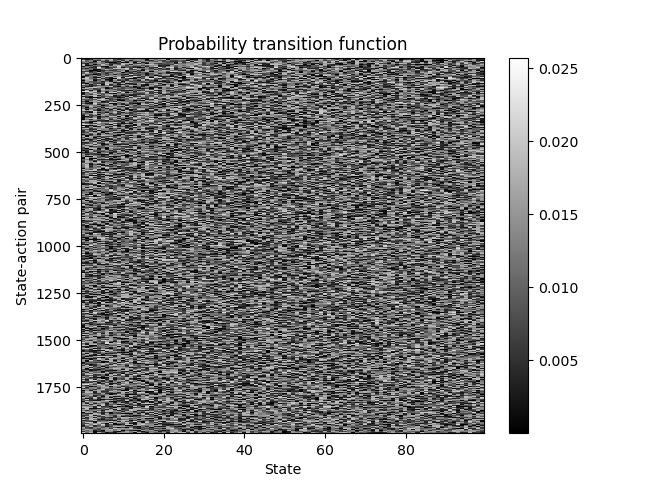

In [120]:
%matplotlib notebook

fig, ax = plt.subplots()
plt.title("Probability transition function")
plt.ylabel("State-action pair")
plt.xlabel("State")
heatmap = plt.imshow(np.reshape(p_mat, (STATES*ACTIONS, STATES)), cmap='gray', interpolation='nearest', aspect='auto')
fig.colorbar(heatmap)
plt.show()

<IPython.core.display.Javascript object>


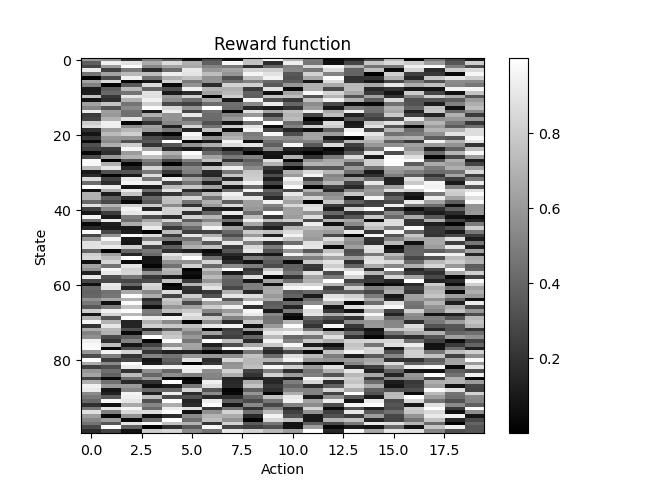

In [122]:
fig, ax = plt.subplots()
plt.title("Reward function")
plt.ylabel("State")
plt.xlabel("Action")
heatmap = plt.imshow(np.reshape(rewards, (STATES, ACTIONS)), cmap='gray', interpolation='nearest', aspect='auto')
fig.colorbar(heatmap)
plt.show()

In [162]:
def bellman(pi, V):
    return rewards[np.arange(STATES), pi] + \
           GAMMA*p_mat[np.arange(STATES), pi]@V

In [286]:
def V_pi(pi):
#     ret = np.zeros(STATES)
#     for i in range(10000): # Pick something vaguely intelligent here
#         ret = bellman(pi, ret)    
    return np.linalg.inv(np.eye(STATES) - GAMMA*p_mat[np.arange(STATES), pi])@rewards[np.arange(STATES), pi]

In [164]:
def Q_pi(V_pi):
    return rewards + GAMMA*p_mat@V_pi

In [165]:
def greedy(Q):
    return Q.argmax(axis=1)

In [189]:
# Policy iteration
pi_value_hist = []
pi_time_hist = []
pi_iter_hist = []

pi = np.random.randint(0, ACTIONS, size=(STATES))

val = V_pi(pi).mean()
# print(f"iter=0, mean value={val}")
# pi_value_hist.append(val)
pi_time_hist.append(1e-3)
pi_iter_hist.append(0)

t0 = time.time()
for i in range(4):
    V_pi_est = V_pi(pi)
    Q_pi_est = Q_pi(V_pi_est)
    pi = greedy(Q_pi_est)
#     val = V_pi(pi).mean()
    
    print(f"iter={i}, mean value={V_pi_est.mean()}")
    pi_value_hist.append(V_pi_est.mean())
    pi_time_hist.append(time.time() - t0)
    pi_iter_hist.append(i)
    
val = V_pi(pi).mean()
print(f"Final policy: {val}")
pi_value_hist.append(val)

iter=0, mean value=526.9827822042254
iter=1, mean value=958.8613281358247
iter=2, mean value=960.9199348756582
iter=3, mean value=960.9255330527998
Final policy: 960.9255330527998


In [183]:
def bellman_star(V):
    return np.max(rewards + GAMMA*p_mat@V, axis=1)

In [184]:
# Value iteration
vi_value_hist = []
vi_time_hist = []
vi_iter_hist = []

V = np.zeros(STATES)

t0 = time.time()
for i in range(10001):
    V = bellman_star(V)
    
    if i % 500 == 0:
        print(f"iter={i}, mean value={V.mean()}")
    vi_value_hist.append(V.mean())
    vi_time_hist.append(time.time() - t0)
    vi_iter_hist.append(i+1)

pi = greedy(Q_pi(V))
print(f"Final policy: mean value={V_pi(pi).mean()}")

iter=0, mean value=0.9610485803548688
iter=500, mean value=378.82328286865646
iter=1000, mean value=607.9509847848193
iter=1500, mean value=746.8891989112095
iter=2000, mean value=831.138406594067
iter=2500, mean value=882.2253522541888
iter=3000, mean value=913.2034004597539
iter=3500, mean value=931.9878366445032
iter=4000, mean value=943.3783232380239
iter=4500, mean value=950.2852744800584
iter=5000, mean value=954.4735042864111
iter=5500, mean value=957.0131586572234
iter=6000, mean value=958.553151594909
iter=6500, mean value=959.4869708875561
iter=7000, mean value=960.0532192449226
iter=7500, mean value=960.3965803263916
iter=8000, mean value=960.6047872566793
iter=8500, mean value=960.73103955538
iter=9000, mean value=960.8075962910523
iter=9500, mean value=960.8540186836514
iter=10000, mean value=960.8821682450938
Final policy: mean value=960.9255330527998


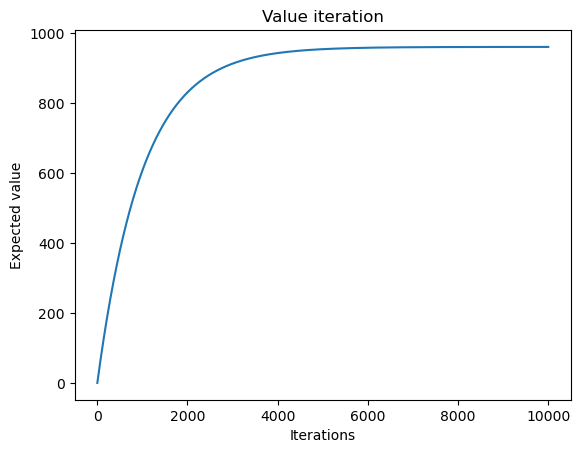

In [185]:
%matplotlib inline
plt.plot(vi_iter_hist, vi_value_hist)
plt.title("Value iteration")
plt.xlabel("Iterations")
plt.ylabel("Expected value")
plt.show()

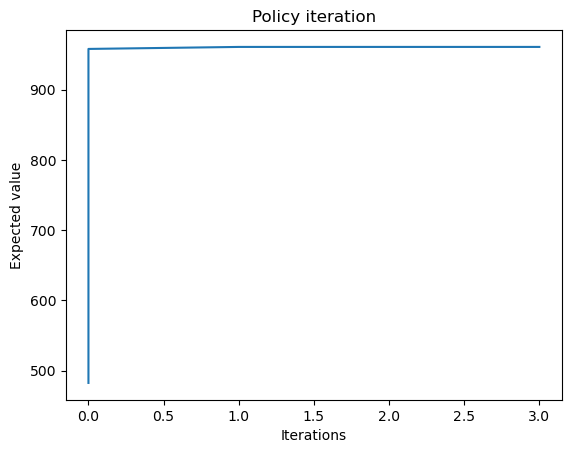

In [186]:
plt.plot(pi_iter_hist, pi_value_hist)
plt.title("Policy iteration")
plt.xlabel("Iterations")
plt.ylabel("Expected value")
plt.show()

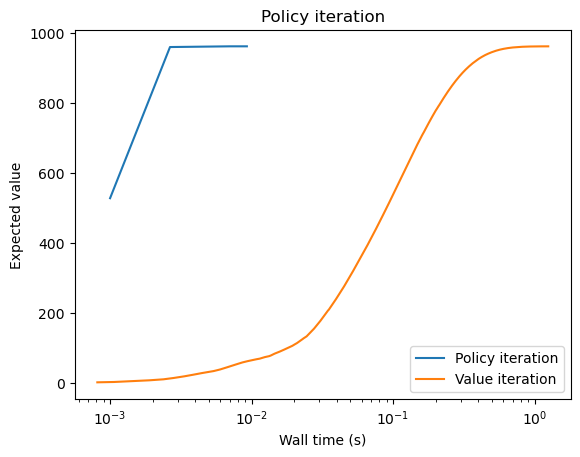

In [193]:
fig, ax = plt.subplots()
plt.plot(pi_time_hist, pi_value_hist, label="Policy iteration")
plt.plot(vi_time_hist, vi_value_hist, label="Value iteration")
ax.set_xscale('log')
plt.title("Policy iteration")
plt.xlabel("Wall time (s)")
plt.ylabel("Expected value")
plt.legend()
plt.show()

In [210]:
c = np.ones(STATES) / STATES
I_vstack = np.zeros((STATES * ACTIONS, STATES))
I_vstack[np.arange(STATES * ACTIONS), np.arange(STATES * ACTIONS)%STATES] = 1
p_mat_2d = np.reshape(p_mat, (STATES*ACTIONS, STATES))
rewards_vec = np.reshape(rewards, (STATES*ACTIONS))

In [211]:
t0 = time.time()
res = scipy.optimize.linprog(c, A_ub=-(I_vstack - GAMMA*p_mat_2d), b_ub=-rewards_vec, bounds=(0, 1/(1-GAMMA)))
t = time.time() - t0
print("LP method converged:", res.success)

LP method converged: True


In [212]:
Q_LP = Q_pi(res.x)
pi_LP = greedy(Q_LP)
V_LP = V_pi(pi_LP)
print(f"LP solution mean value: {V_LP.mean():.3f}. Time to solution: {t:.3f}s")

LP solution mean value: 960.827. Time to solution: 0.179s


In [355]:
c = np.reshape(rewards, (STATES*ACTIONS), order='F')
rho = np.ones(STATES)# / STATES
I_hstack = np.zeros((STATES, STATES*ACTIONS))
I_hstack[np.arange(STATES * ACTIONS)%STATES, np.arange(STATES * ACTIONS)] = 1
reshaped = np.transpose(p_mat, (2, 1, 0))
p_mat_2d = np.reshape(reshaped, (STATES, STATES*ACTIONS), order='C')

In [356]:
t0 = time.time()
res = scipy.optimize.linprog(-c, A_eq=(I_hstack - GAMMA*p_mat_2d), b_eq=rho, bounds=(0, None))
t = time.time() - t0
print("LP dual method converged:", res.success)

LP dual method converged: True


In [363]:
mu = np.reshape(res.x, (STATES,ACTIONS), order='F')
pi_p = mu / mu.sum(axis=1)[:, np.newaxis]
assert((pi_p >= 0).sum() == pi_p.size) # Assert it consists of only non-negative numbers
assert(np.array_equal(pi_p.sum(axis=1), np.ones(STATES))) # Assert pi is a valid probabilistic policy
assert(np.array_equal(pi_p.max(axis=1), np.ones(STATES))) # Assert that really, pi is deterministic
pi_d = np.argmax(pi_p, axis=1) # Convert to deterministic policy
V_LP_dual = V_pi(pi_d)
print(f"LP dual solution mean value: {V_LP_dual.mean():.3f}. Time to solution: {t:.3f}s")

LP dual solution mean value: 960.926. Time to solution: 0.360s


In [360]:
(pi_p >= 0).

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [265]:
mu.sum(axis=1)

array([0.18565775, 0.18694959, 0.20932488, 0.20319134, 0.18352559,
       0.17859292, 0.20598299, 0.18287575, 0.20115334, 0.188431  ,
       0.18283885, 0.19948958, 0.18679563, 0.18623141, 0.18449859,
       0.18754019, 0.19555404, 0.20308791, 0.1975648 , 0.18547127,
       0.20116672, 0.18596418, 0.18979751, 0.18337608, 0.19089819,
       0.18869967, 0.20138886, 0.19121569, 0.17233864, 0.19445255,
       0.18893529, 0.18036178, 0.20014916, 0.18528658, 0.19927121,
       0.18933484, 0.20107272, 0.19348976, 0.19379787, 0.18614369,
       0.18332136, 0.19067523, 0.1935404 , 0.1788472 , 0.19229045,
       0.18417659, 0.18107812, 0.19429461, 0.1852544 , 0.19490646,
       0.19094562, 0.16254006, 0.18700333, 0.19604541, 0.19849536,
       0.17441992, 0.1895351 , 0.21035939, 0.190053  , 0.18627517,
       0.17887004, 0.20010437, 0.16429017, 0.19984889, 0.20050759,
       0.19188705, 0.17690291, 0.19646994, 0.20875068, 0.18897574,
       0.18053218, 0.18202558, 0.17667712, 0.20295192, 0.18613

In [262]:
print(np.reshape(res.x, (STATES,ACTIONS)))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.18519245 0.         0.         ... 0.         0.         0.        ]]


In [359]:
with np.printoptions(threshold=np.inf):
    print(pi_p)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [307]:
res

       message: The problem is unbounded. (HiGHS Status 10: model_status is Unbounded; primal_status is At upper bound)
       success: False
        status: 3
           fun: None
             x: None
           nit: 415
         lower:  residual: None
                marginals: None
         upper:  residual: None
                marginals: None
         eqlin:  residual: None
                marginals: None
       ineqlin:  residual: None
                marginals: None